In [1]:
import corneto as cn
import pandas as pd
import numpy as np

from corneto.methods.metabolism.fba import multicondition_imat
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    jaccard_score, hamming_loss
)

pd.__version__, np.__version__

('2.2.3', '1.26.4')


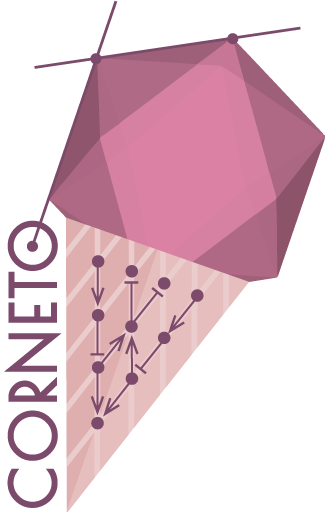

In [2]:
cn.info()

In [3]:
# GPR-parsed gene expression from 01_data_processing.ipynb notebook
df_data = pd.read_csv("output/input_data.csv").set_index("Rxn name")
df_data

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,1,1,1,1,0,0,1,1,0,0,1,0
r_0002,0,0,0,0,0,0,0,0,0,0,0,0
r_0003,0,1,0,1,1,1,0,1,-1,0,0,0
r_0004,1,1,1,1,1,1,1,1,0,1,1,1
r_0005,1,1,1,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0,0,0,0,0,0,0,0,0,0,0,0
r_4695,0,0,0,0,0,0,0,0,0,0,0,0
r_4697,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/SysBioChalmers/Yeast-GEM/v8.5.0/default.miom")
G.shape

(2742, 4058)

In [5]:
# Metadata of the Yeast 8.5.0 (from SysBioChalmers github)
df_yeastn = pd.read_csv("yeast-GEM.txt", sep="\t")

In [6]:
n_splits = 5

# NOTE: For the experiments, we run this for different lambdas and we repeated the results 10 times (with different seed)
gaps = [0.10]
eps = 1e-3
seed = 0
lambdas = [0.1]

# More time is needed, especially for larger lambdas
norel = 120
maxtime = 300

In [7]:
# We cannot leave out entire conditions. Instead, we perform a K-Fold by leaving out data
# i.e., assigned scores, which are -1s or 1s assigned to reactions, from the reconstruction
# and across conditions. A similar strategy was described (for a single condition) in the
# original iMAT paper (Shlomi et al. 2008) https://www.nature.com/articles/nbt.1487

def combine(df_data, df_fold):
    dfc = pd.concat([df_data, df_fold])
    dfc = dfc[~dfc.index.duplicated(keep='last')]
    return dfc.loc[df_data.index]
    
def create_folds(df, n_splits=n_splits, seed=0):
    # Get the sub-df with at least some values
    folds = []
    # Find where there is data (-1s or 1s)
    df_sub = df[df.abs().sum(axis=1) > 0]
    # Stack the df and split with KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    df_sub_stacked = df_sub.stack()
    for idx_train, _ in kf.split(df_sub_stacked):
        df_train = df_sub_stacked.iloc[idx_train].unstack()
        df_train = combine(df, df_train)
        folds.append(df_train)
    return folds

def compute_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    return TP, TN, FP, FN

folds = create_folds(df_data, n_splits=n_splits, seed=seed)
len(folds)

5

In [8]:
# Data is replaced with NaNs
folds[0]

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,1.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0
r_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_0003,NaN,1.0,0.0,1.0,NaN,1.0,NaN,1.0,-1.0,0.0,0.0,0.0
r_0004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0
r_0005,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_4695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_4697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
folds[1]

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,1.0,NaN,1.0,1.0,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0
r_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_0003,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0
r_0004,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN
r_0005,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_4695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r_4697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print("Running multi-condition iMAT...")
results = []
for g in gaps:
    for l in lambdas:
        print(f"Running multi-cond for MIP-gap {g}...")
        for i, f_train in enumerate(folds):
            print(f"Fold {i}, gap={g}, lambda={l}, norel={norel}, eps={eps}")
            w = f_train.fillna(0).values
            print("RH:", np.sum(w>0), "RL:", np.sum(w<0), "Unknown:", np.sum(w==0))
            P = multicondition_imat(G, w, eps=eps, alpha=l)
            P.solve(solver="GUROBI", verbosity=1, Seed=seed, IntegralityFocus=1, NoRelHeurTime=norel, TimeLimit=maxtime, MIPGap=g)
            cum_err = 0
            errors = []
            for j, o in enumerate(P.objectives):
                cum_err += o.value
                errors.append(o.value)
            print(f"Total training error = {cum_err}")
            sol=pd.DataFrame((np.abs(P.expr.flow.value) >= eps*(1-eps)).astype(int), index=df_data.index, columns=df_data.columns)
            selected_reactions = (sol.sum(axis=1) > 0).sum()
            val_pos = (df_data[f_train.isna()] > 0).sum()
            val_neg = (df_data[f_train.isna()] < 0).sum()
            print("Validation positive:")
            print(val_pos)
            print("Validation negative:")
            print(val_neg)
            
            # Compute metrics
            # We select the validation data (only -1s or 1s) and clip to have only 0s and 1s
            df_data_true = pd.DataFrame(df_data[f_train.isna()].clip(0, 1).stack(), columns=["y_true"])
            # Get the same values from the network inferred. The inferred network have a 0 if reaction not selected, 1 if selected.
            df_pred_multi = pd.DataFrame(sol[f_train.isna()].stack(), columns=["y_pred"])
            df_data_pred_multi = df_data_true.join(df_pred_multi)
            # Compute accuracy, f1 score and roc auc score
            acc = accuracy_score(df_data_pred_multi.y_true, df_data_pred_multi.y_pred)
            roc_auc = roc_auc_score(df_data_pred_multi.y_true, df_data_pred_multi.y_pred)
            TP, TN, FP, FN = compute_confusion_matrix(df_data_pred_multi.y_true, df_data_pred_multi.y_pred)
            TPR = TP / (TP + FN) # recall
            PPV = TP / (TP + FP) # precision
            F1 = 2 * ((PPV * TPR) / (PPV + TPR))
            result = {
                'fold': i,
                'val_n_pos': val_pos.sum(),
                'val_n_neg': val_neg.sum(),
                'mip_gap': g,
                'lambda': l,
                'norel': norel,
                'eps': eps,
                'n_rxns': selected_reactions,
                'total_error': cum_err,
                'abs_val_err': np.sum(np.abs(df_data_pred_multi.y_true - df_data_pred_multi.y_pred)),
                'TP': np.round(TP, 3),
                'TN': np.round(TN, 3),
                'FP': np.round(FP, 3),
                'FN': np.round(FN, 3),
                'TPR_RECALL': np.round(TPR, 3),
                'PPV_PRECISION': np.round(PPV, 3),
                'F1': np.round(F1, 3),
                'seed': seed
            }
            print(result)
            results.append(result)
            pd.DataFrame(results).to_csv(f"output/results_seed{seed}.csv")

Running multi-condition iMAT...
Running multi-cond for MIP-gap 0.1...
Fold 0, gap=0.1, lambda=0.1, norel=120, eps=0.001
RH: 4682 RL: 1357 Unknown: 42657
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 23 10:37:42 AM: Your problem has 150146 variables, 634852 constraints, and 0 parameters.
(CVXPY) Dec 23 10:37:42 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 23 10:37:42 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 23 10:37:42 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 23 10:37:42 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                         

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Total training error = 4209.0000029999965
Validation positive:
opi3-del vs. wt     199
ram1-del vs. wt     179
cho2-del vs. wt     138
aco1-del vs. wt      95
pfk2-del vs. wt      82
ipk1-del vs. wt      64
vps15-del vs. wt     98
sis2-del vs. wt      68
arg82-del vs. wt     57
plc1-del vs. wt      43
rnr4-del vs. wt      88
pfk27-del vs. wt     59
dtype: int64
Validation negative:
opi3-del vs. wt     55
ram1-del vs. wt     60
cho2-del vs. wt     38
aco1-del vs. wt     28
pfk2-del vs. wt      7
ipk1-del vs. wt     29
vps15-del vs. wt    15
sis2-del vs. wt     20
arg82-del vs. wt    37
plc1-del vs. wt     20
rnr4-del vs. wt     10
pfk27-del vs. wt    11
dtype: int64
{'fold': 0, 'val_n_pos': 1170, 'val_n_neg': 330, 'mip_gap': 0.1, 'lambda': 0.1, 'norel': 120, 'eps': 0.001, 'n_rxns': 1570, 'total_error': 4209.0000029999965, 'abs_val_err': 1534.0, 'TP': 267, 'TN': 2791, 'FP': 631, 'FN': 903, 'TPR_RECALL': 0.228, 'PPV_PRECISION': 0.297, 'F1': 0.258, 'seed': 0}
Fold 1, gap=0.1, lambda=0.1, n

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Total training error = 4273.0
Validation positive:
opi3-del vs. wt     203
ram1-del vs. wt     185
cho2-del vs. wt     157
aco1-del vs. wt     128
pfk2-del vs. wt      98
ipk1-del vs. wt      71
vps15-del vs. wt     93
sis2-del vs. wt      66
arg82-del vs. wt     37
plc1-del vs. wt      48
rnr4-del vs. wt      69
pfk27-del vs. wt     62
dtype: int64
Validation negative:
opi3-del vs. wt     65
ram1-del vs. wt     52
cho2-del vs. wt     37
aco1-del vs. wt     31
pfk2-del vs. wt     14
ipk1-del vs. wt     17
vps15-del vs. wt    20
sis2-del vs. wt     22
arg82-del vs. wt    44
plc1-del vs. wt     18
rnr4-del vs. wt      9
pfk27-del vs. wt    12
dtype: int64
{'fold': 1, 'val_n_pos': 1217, 'val_n_neg': 341, 'mip_gap': 0.1, 'lambda': 0.1, 'norel': 120, 'eps': 0.001, 'n_rxns': 1554, 'total_error': 4273.0, 'abs_val_err': 1472.0, 'TP': 255, 'TN': 2864, 'FP': 510, 'FN': 962, 'TPR_RECALL': 0.21, 'PPV_PRECISION': 0.333, 'F1': 0.257, 'seed': 0}
Fold 2, gap=0.1, lambda=0.1, norel=120, eps=0.001
RH: 4

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Total training error = 4056.0
Validation positive:
opi3-del vs. wt     186
ram1-del vs. wt     190
cho2-del vs. wt     135
aco1-del vs. wt      92
pfk2-del vs. wt      86
ipk1-del vs. wt      50
vps15-del vs. wt     95
sis2-del vs. wt      65
arg82-del vs. wt     34
plc1-del vs. wt      61
rnr4-del vs. wt      85
pfk27-del vs. wt     51
dtype: int64
Validation negative:
opi3-del vs. wt     62
ram1-del vs. wt     50
cho2-del vs. wt     26
aco1-del vs. wt     21
pfk2-del vs. wt      9
ipk1-del vs. wt     23
vps15-del vs. wt    20
sis2-del vs. wt     18
arg82-del vs. wt    71
plc1-del vs. wt     16
rnr4-del vs. wt     11
pfk27-del vs. wt    10
dtype: int64
{'fold': 2, 'val_n_pos': 1130, 'val_n_neg': 337, 'mip_gap': 0.1, 'lambda': 0.1, 'norel': 120, 'eps': 0.001, 'n_rxns': 1595, 'total_error': 4056.0, 'abs_val_err': 1534.0, 'TP': 264, 'TN': 2793, 'FP': 668, 'FN': 866, 'TPR_RECALL': 0.234, 'PPV_PRECISION': 0.283, 'F1': 0.256, 'seed': 0}
Fold 3, gap=0.1, lambda=0.1, norel=120, eps=0.001
RH: 

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Total training error = 4111.0
Validation positive:
opi3-del vs. wt     227
ram1-del vs. wt     193
cho2-del vs. wt     131
aco1-del vs. wt     106
pfk2-del vs. wt      79
ipk1-del vs. wt      67
vps15-del vs. wt     93
sis2-del vs. wt      57
arg82-del vs. wt     44
plc1-del vs. wt      46
rnr4-del vs. wt      60
pfk27-del vs. wt     51
dtype: int64
Validation negative:
opi3-del vs. wt     57
ram1-del vs. wt     47
cho2-del vs. wt     38
aco1-del vs. wt     38
pfk2-del vs. wt     14
ipk1-del vs. wt     25
vps15-del vs. wt    14
sis2-del vs. wt     19
arg82-del vs. wt    53
plc1-del vs. wt     18
rnr4-del vs. wt      9
pfk27-del vs. wt    12
dtype: int64
{'fold': 3, 'val_n_pos': 1154, 'val_n_neg': 344, 'mip_gap': 0.1, 'lambda': 0.1, 'norel': 120, 'eps': 0.001, 'n_rxns': 1679, 'total_error': 4111.0, 'abs_val_err': 1519.0, 'TP': 274, 'TN': 2798, 'FP': 639, 'FN': 880, 'TPR_RECALL': 0.237, 'PPV_PRECISION': 0.3, 'F1': 0.265, 'seed': 0}
Fold 4, gap=0.1, lambda=0.1, norel=120, eps=0.001
RH: 46

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [11]:
df_data.values

array([[1, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Extraction of solutions for $\lambda=0$ and $\lambda=1.5$

After selecting the optimal lambda = 1.5, we perform the reconstruction with the full df_data matrix

In [12]:
P = multicondition_imat(G, df_data.values, eps=eps, alpha=0)
P.solve(solver="GUROBI", verbosity=1, IntegralityFocus=1, NoRelHeurTime=norel, TimeLimit=maxtime, MIPGap=0.10)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 27 11:00:31 AM: Your problem has 146088 variables, 626736 constraints, and 0 parameters.
(CVXPY) Dec 27 11:00:31 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 27 11:00:31 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 27 11:00:31 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 27 11:00:31 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 27 11:00:31 AM: Compiling problem (target solver=GU

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, UNKNOWN, (4058, 12))), Inequality(Variable((4058, 12), _flow)), Equality(Expression(AFFINE, UNKNOWN, (2742, 12)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (4058, 12))), Equality(Expression(AFFINE, NONNEGATIVE, (60, 12)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (29136, 12)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (4058, 12))), Inequality(Variable((4058, 12), _flow))])

In [14]:
sol_flux_l0 = pd.DataFrame(P.expr.flow.value, index=df_data.index, columns=df_data.columns)
sol_l0 = pd.DataFrame((np.abs(P.expr.flow.value) >= eps*(1-eps)).astype(int), index=df_data.index, columns=df_data.columns)
sol_flux_l0.to_csv("result_l0_gap0.10_flux.csv")
sol_l0.to_csv("result_l0_gap0.10.csv")

In [17]:
# NOTE: More time might be needed to achieve a 10% GAP
P = multicondition_imat(G, df_data.values, eps=1e-3, alpha=1.5)
P.solve(solver="GUROBI", verbosity=1, IntegralityFocus=1, NoRelHeurTime=600, TimeLimit=1200, MIPGap=0.10)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 27 11:12:55 AM: Your problem has 150146 variables, 634852 constraints, and 0 parameters.
(CVXPY) Dec 27 11:12:55 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 27 11:12:55 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 27 11:12:55 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 27 11:12:55 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 27 11:12:55 AM: Compiling problem (target solver=GU

Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, UNKNOWN, (4058, 12))), Inequality(Variable((4058, 12), _flow)), Equality(Expression(AFFINE, UNKNOWN, (2742, 12)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (4058, 12))), Equality(Expression(AFFINE, NONNEGATIVE, (60, 12)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (29136, 12)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (4058, 12))), Inequality(Variable((4058, 12), _flow)), Inequality(Expression(AFFINE, NONNEGATIVE, (4058,))), Inequality(Variable((4058,), _or, boolean=True))])

In [18]:
sol_flux_l15 = pd.DataFrame(P.expr.flow.value, index=df_data.index, columns=df_data.columns)
sol_l15 = pd.DataFrame((np.abs(P.expr.flow.value) >= eps*(1-eps)).astype(int), index=df_data.index, columns=df_data.columns)
sol_flux_l15.to_csv("result_l1.5_gap0.10_flux.csv")
sol_l15.to_csv("result_l1.5_gap0.10.csv")